# Домашнее задание 2. Работа с изображениями

В этом задании предлагается решить простейшую задачу рапознавания лиц. Вам нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

__Задание__. Вам потребуется выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

__Во всех заданиях будем придерживаться следующих правил__:
1. Использовать внешние данные для обучения строго запрещено. Также запрещено обучаться на валидационной выборке.
2. Все задания должны быть выполнены без использования предобученных моделей и готовых реализаций. Тем не менее:
    - В заданиях, где требуется достичь некоторого качества модели, разрешается использовать предобученные модели. Но __оценка за задние будет снижена__ (для каждого задания будет отдельно указано, на сколько).
    - В некоторых заданиях может сильно помочь библотека [pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). Вы можете использовать готовые реализации из неё, но __максимальный балл за задание также будет снижен__.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о том, как заставить это всё работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Рекомендуем использовать шаблоны ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Правильно нормализуйте данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени. Можно написать свою модель руками, а можно импортировать не предобученную сетку известной архитектуры из модуля `torchvision.models`. Один из способов как можно сделать: [документация (полезная)](https://pytorch.org/vision/stable/models.html)
 - Используйте все возможные методы оптимизации и эксперемнтируйте с ними.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
    * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
    * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [1]:
import os
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pandas as pd
import random
from torchvision import transforms
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2
import tqdm
from IPython.display import clear_output

In [ ]:
# Можно использовать, но балл за соответствующие задания будет снижен.
import pytorch_metric_learning.distances
import pytorch_metric_learning.samplers
import pytorch_metric_learning.losses

In [2]:
# Обязательно вызывайте эту функцию перед каждый запуском обучения!
# Если проверяющий не сможет воспроизвести результат, оценка за задание будет снижена.
def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### [1.5 балла] Часть 1. Подготовка данных.

##### [0.5 балла] Задание 1.1. Считать датасет.

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [3]:
!unzip -q data.zip
!rm data.zip

In [4]:
# сначала найдем mean и std по всем каналам для нормализации, а также убедимся, что размер всех изображений одинаковый
train_ds_first = torchvision.datasets.ImageFolder("data/training", transform = transforms.ToTensor())
test_ds_first = torchvision.datasets.ImageFolder("data/testing", transform = transforms.ToTensor())
image_sizes = []
for i, l in train_ds_first:
  image_sizes.append(i.shape)
set(image_sizes)

{torch.Size([3, 250, 250])}

In [5]:
# получим mean и std
# подсмотрено здесь: https://stackoverflow.com/questions/64365215/finding-means-and-stds-of-a-bunch-of-torch-tensors-that-are-converted-from-ndar
image_arr = torch.stack([item[0] for item in train_ds_first])
mean = torch.mean(image_arr, dim=[0, 2, 3])
std = torch.std(image_arr, dim=[0, 2, 3])

print(f"Среднее по каналам: {mean}")
print(f"Стандартное отклонение по каналам: {std}")


Среднее по каналам: tensor([0.4299, 0.3747, 0.3324])
Стандартное отклонение по каналам: tensor([0.2971, 0.2721, 0.2654])


In [6]:
set_random_seed(42)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
)

train_ds = torchvision.datasets.ImageFolder("data/training", transform = transform)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform = transform)

Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

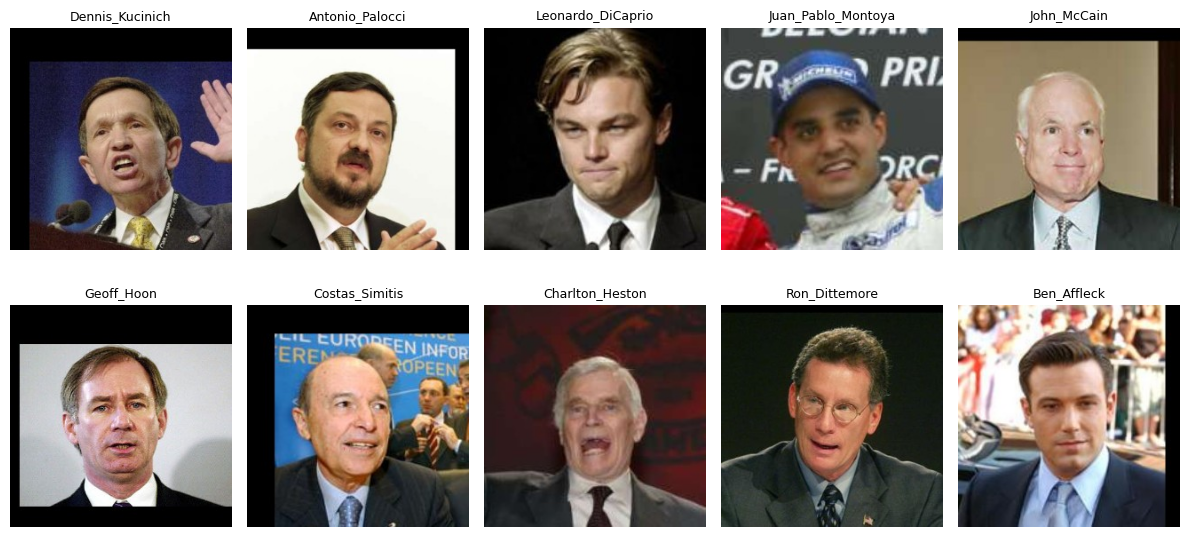

In [7]:
def show_images(dataset):
  plt.figure(figsize = (12, 6))

  for i in range(10):
    ind = random.randint(0, len(dataset) - 1)
    img, label = dataset[ind]
    img = img.permute(1, 2, 0).numpy()

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(dataset.classes[label], fontsize=9)
    plt.axis('off')

  plt.tight_layout()
  plt.show()

show_images(train_ds_first)

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

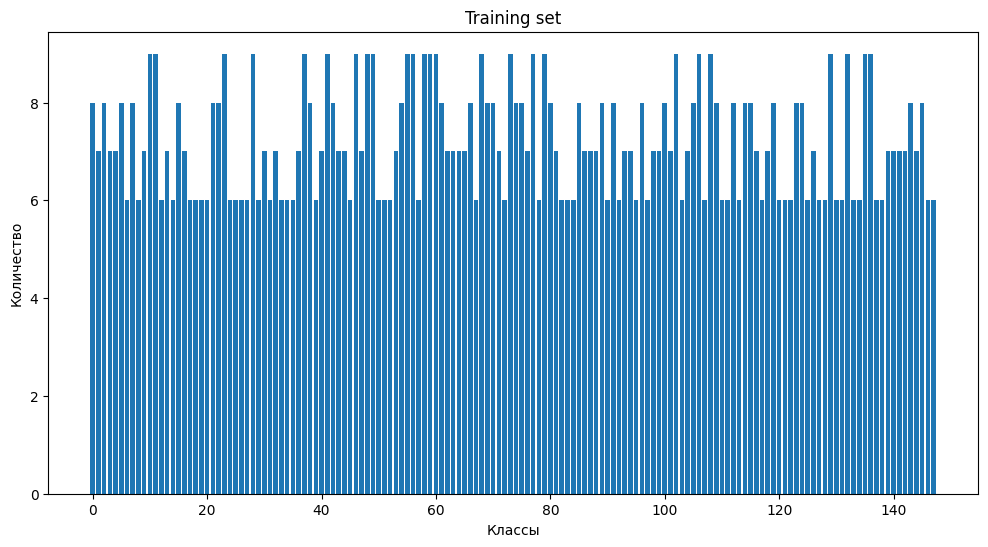

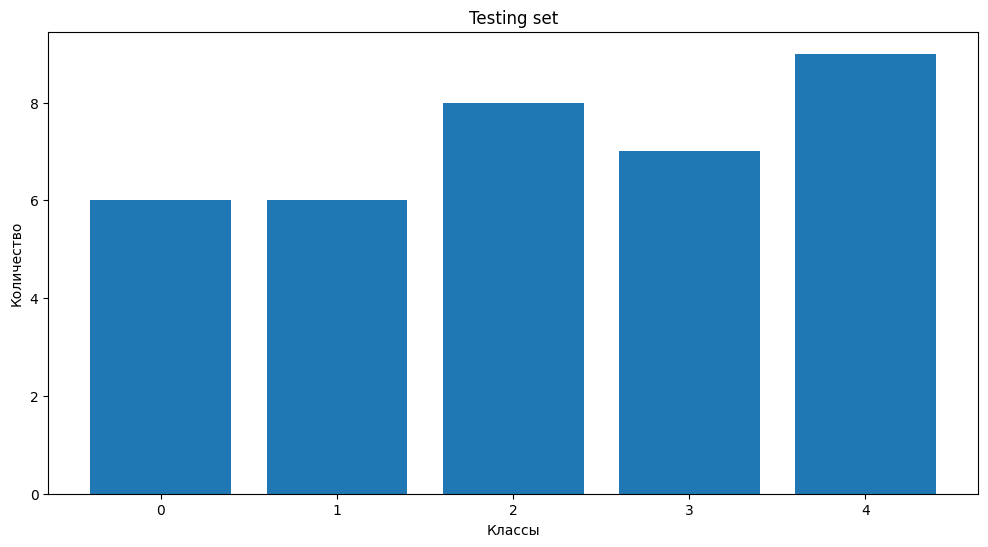

In [8]:
from collections import Counter

def show_class_distribtion(targets, name):
  counts = Counter(np.array(targets))
  unique_classes = sorted(counts.keys())
  values = [counts[c] for c in unique_classes]

  plt.figure(figsize=(12, 6))
  plt.bar(unique_classes, values)
  plt.xlabel('Классы')
  plt.ylabel('Количество')
  plt.title(name)
  plt.show()

show_class_distribtion(train_ds.targets, 'Training set')
show_class_distribtion(test_ds.targets, 'Testing set')

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [9]:
# Разделим train на обучающую и валидационную выборку
from torch.utils.data import random_split, DataLoader

train_ds_split, val_ds_split = random_split(
    train_ds, [0.8, 0.2],
    generator=torch.Generator().manual_seed(42))
# У меня возникла проблема с тем, что дальше не работало PairDataset из-за того,
# что random_split возвращает subset, у которого нет targets, поэтому воспользовалась этим https://stackoverflow.com/questions/73200934/how-to-find-features-and-targets-for-subset-of-data
train_ds_split.targets = [train_ds.targets[i] for i in train_ds_split.indices]
val_ds_split.targets = [train_ds.targets[i] for i in val_ds_split.indices]

In [10]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)

    def _idx2(self, idx):
        return idx // len(self.dataset)

    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)

train_pairs = PairDataset(train_ds_split)
val_pairs = PairDataset(val_ds_split)
test_pairs = PairDataset(test_ds)

100%|██████████| 1296/1296 [00:00<00:00, 1531647.78it/s]


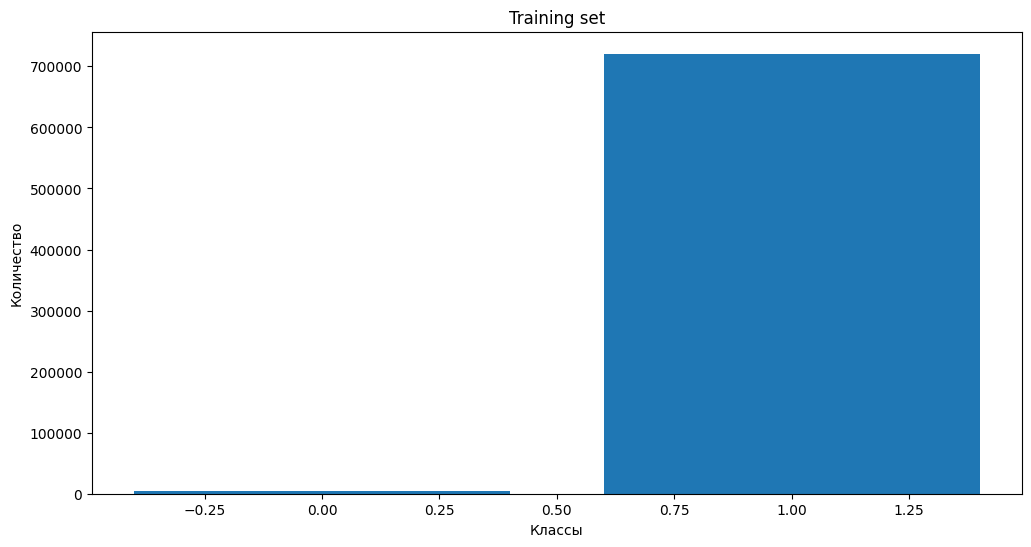

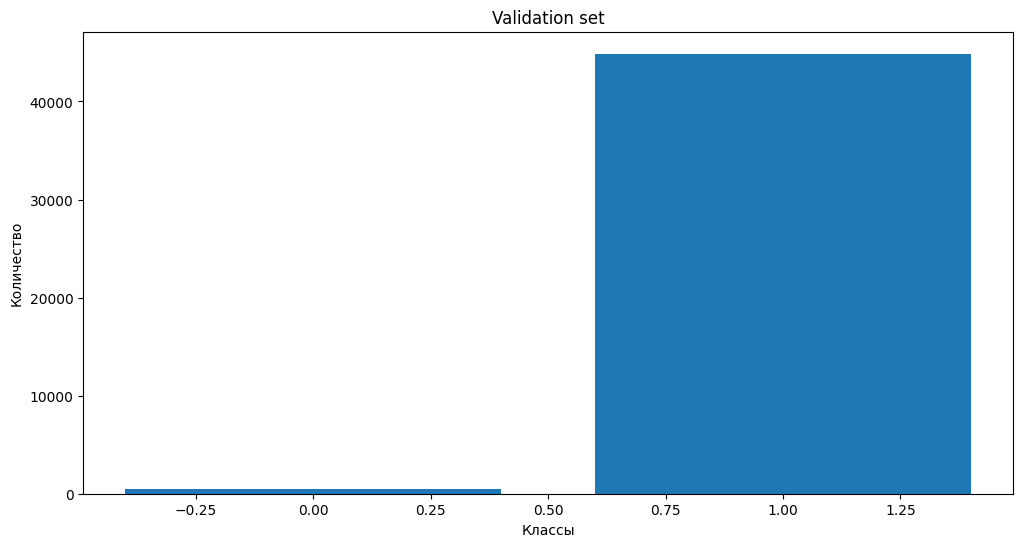

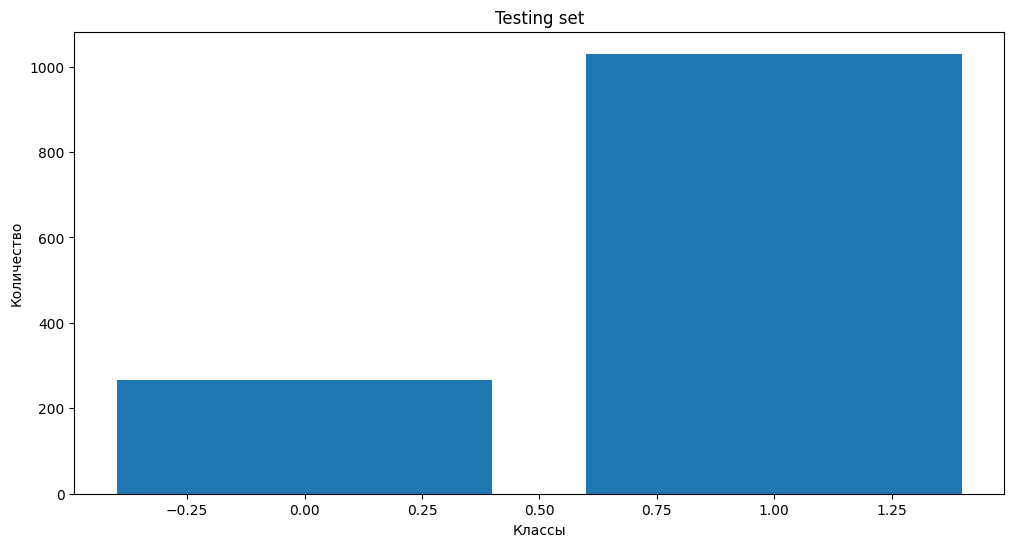

In [11]:
show_class_distribtion(train_pairs.targets, 'Training set')
show_class_distribtion(val_pairs.targets, 'Validation set')
show_class_distribtion(test_pairs.targets, 'Testing set')

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [12]:
import numpy as np
from torch.utils.data import Sampler

class BalancedPairSampler(Sampler):

    def __init__(self, targets, batch_size):
        assert batch_size % 2 == 0
        self.targets = np.array(targets)
        self.batch_size = batch_size
        self.half_batch = batch_size // 2

        self.ind0 = np.where(self.targets == 0)[0]
        self.ind1 = np.where(self.targets == 1)[0]

        self.replace0 = len(self.ind0) < self.half_batch
        self.replace1 = len(self.ind1) < self.half_batch

        self.num_batches = min(
            len(self.ind0) // self.half_batch,
            len(self.ind1) // self.half_batch
        )

    def __iter__(self):
        for _ in range(self.num_batches):
            part0 = np.random.choice(self.ind0, self.half_batch, replace=self.replace0)
            part1 = np.random.choice(self.ind1, self.half_batch, replace=self.replace1)
            batch_ind = np.concatenate([part0, part1])
            np.random.shuffle(batch_ind)
            yield batch_ind.tolist()

    def __len__(self):
        return self.num_batches


In [13]:
train_pairs_sampler = BalancedPairSampler(
    targets = train_pairs.targets,
    batch_size = 32
)

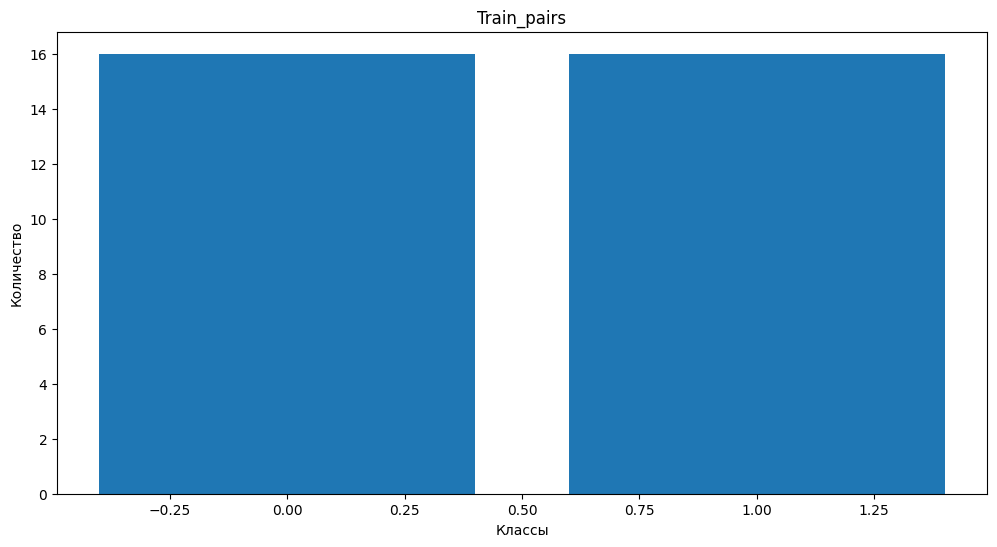

In [14]:
train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_sampler = train_pairs_sampler)
val_pairs_loader = torch.utils.data.DataLoader(val_pairs, batch_size = 64, shuffle = False)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)

# Убедимся, что теперь выдача равномерная.
show_class_distribtion(next(iter(train_pairs_loader))[2], 'Train_pairs')

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

Сначала нужно реализовать модель. В `forward` необходимо принять два батча фотографий. `i`-e число в выводе `forward` должно быть предсказанием для пары из `i`-й фотографии `image1` и `i`-й фотографии `image2`. Подумайте, как это сделать. Возможно, стоит как-нибудь склеить `image1` и `image2`? Или склеить эмбеддинги? А может быть нужен какой-то трешхолд?

Вы вольны использовать любую архитектуру сети. Ассерт в конце ячейки поможет вам убедиться, что модель теоретически делает то, что нужно.

In [15]:
def plot_losses_auc(train_losses, val_losses, val_auc_rocs):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', marker='o')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val', marker='o')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    axs[0].set_title('Training and Validation Loss')
    axs[0].grid(alpha=0.3)

    # AUC-ROC
    axs[1].plot(range(1, len(val_auc_rocs) + 1), val_auc_rocs, label='val', color='red', marker='o')
    axs[1].set_ylabel('AUC-ROC')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    axs[1].set_title('Validation AUC-ROC')
    axs[1].grid(alpha=0.3)
    axs[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [16]:
from tqdm import tqdm

class ClassificationNet(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding='same'), # 250x250
          nn.BatchNorm2d(4),
          nn.ReLU(),
          nn.MaxPool2d(2), # 125x125

          nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding='same'),
          nn.BatchNorm2d(8),
          nn.ReLU(),
          nn.MaxPool2d(2), # 62x62

          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2), #31x31

          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2), #15x15

          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2), #7x7

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2), #3x3

          nn.Flatten(),

          nn.Linear(in_features=3 * 3 * 128, out_features=256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(0.3),
      )

      self.classifier = nn.Sequential(
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(128, 1),
          nn.Sigmoid()
      )

        ### YOUR CODE HERE ###


    def forward(self, image1, image2):
      emb1 = self.model(image1)
      emb2 = self.model(image2)

      combined = torch.abs(emb1 - emb2)

      result = self.classifier(combined)
      return result.squeeze(1)


# Вы можете использовать этот ассерт в качестве теста, что ваша модель делает то, что нужно.
assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

In [17]:
def training_epoch(model,  optimizer, criterion,train_loader, tqdm_desc):
  '''Одна эпоха обучения (спасибо семинарскому блокноту)'''
  train_loss = 0.0

  model.train()
  for image1, image2, labels in tqdm(train_loader, desc=tqdm_desc):
    image1 = image1.to(device)
    image2 = image2.to(device)
    labels = labels.float().to(device)

    optimizer.zero_grad()
    outputs = model(image1, image2)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * labels.size(0)

  train_loss /= len(train_loader.dataset)
  return train_loss

def validation_epoch(model, criterion, val_loader, tqdm_desc):
  '''Прогнозы на валидации'''
  val_loss = 0.0
  preds = []
  targets = []

  model.eval()
  for image1, image2, labels in tqdm(val_loader, desc=tqdm_desc):
      image1 = image1.to(device)
      image2 = image2.to(device)
      labels = labels.float().to(device)

      outputs = model(image1, image2)
      loss = criterion(outputs, labels)

      val_loss += loss.item() * labels.size(0)
      preds.extend(outputs.detach().cpu().numpy())
      targets.extend(labels.cpu().numpy())


  val_loss /= len(val_loader.dataset)
  auc_roc = sklearn.metrics.roc_auc_score(targets, preds)

  return val_loss, auc_roc, preds, targets

def train(
    model, optimizer, criterion, train_loader, val_loader, num_epochs):
    """Обучение модели"""
    train_losses = []
    val_losses = []
    val_auc_rocs = []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        val_loss, auc_roc, _, _ = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_auc_rocs.append(auc_roc)

        plot_losses_auc(train_losses, val_losses, val_auc_rocs)

        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, auc_roc: {np.mean(auc_roc)}")

##### [2 балла] Задание 2.2. Обучение.

Теперь обучите свою модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 2.5 \cdot \dfrac{AucRoc - 0.6}{0.2}, 2.5) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.8`

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1)

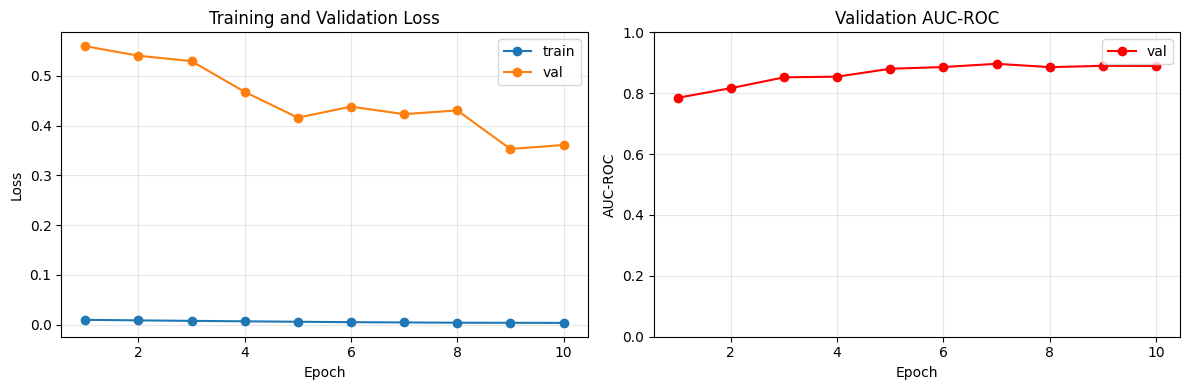

Epoch: 10, loss: 0.36126170028795496, auc_roc: 0.889497145420616


In [ ]:
set_random_seed(42)

num_epoch = 10
lr = 0.001

model = ClassificationNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model, optimizer, criterion, train_pairs_loader, val_pairs_loader, num_epoch)

In [ ]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

auc_roc = get_auc_roc(model)
score = get_score(auc_roc)
print()
print(f'auc_roc = {round(auc_roc, 3)}')
print(f'Балл = {score}')

100%|██████████| 21/21 [00:05<00:00,  3.98it/s]


auc_roc = 0.96
Балл = 2.5


##### [0.5 балла] Задание 2.3. Анализ и отчет.

Опишите свои эксперименты. Проанализируйте результаты. Почему результаты получились не очень хорошими? Может быть, решать задачу через бинарную классификацию - не лучшая идея? Приведите не менее 3 аргументов, почему это так.

**Эксперименты:**
1) Изначально (обычные слои + дропаут, 5 эпох, "сложение" эмбедингов), лосс и аук-роки не менялись с эпохами, оставались почти константными
2) Я добавила BatchNormalization, уже стало получше, но все еще близко к постоянным значениям. (рок-аук колеблется около 0.5 (плохо-плохо))
3) Поменяла склеивание эмбедингов на взятие модуля их разности из соображений, что мы смотрим на различия между картинками
4) Финальный этап: увеличила количество количество эпох с 5 до 10: auc_roc на валидационной выборке увеличился до 0.889

Я бы не сказала, что результаты получились совсем плохими, но присутствует проблема переобучения (train_loss остается околонулевым на протяжении всех эпох) Подумаем, почему решать задачу через бинарную классификацию может быть не лучшей идеей:
1) при n изображениях в выборке, мы получаем n^2 пар в pair dataset, большинство из которых являются 1 классом (то есть люди различаются), что приводит к дисбалансу классов, хотя мы и сделали sampler
2) классификация просто говорит, похожи или нет, но не говорит насколько
3) быстрое переобучение (возможно, модель быстро запомнила очевидные пары, где есть очевидные различия)

### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [18]:
# c помощью статьи https://www.v7labs.com/blog/triplet-loss
class TripletLoss(torch.nn.Module):
  def __init__(self, margin):
    super().__init__()
    self.margin = margin

  def forward(self, embeddings, labels):
    batch_size = embeddings.size(0)
    pairwise_dist = torch.cdist(embeddings, embeddings, p = 2)

    loss = 0.0
    count = 0

    for i in range(batch_size):
      positive_mask = labels == labels[i]
      negative_mask = labels != labels[i]

      positive_dist = pairwise_dist[i][positive_mask]
      negative_dist = pairwise_dist[i][negative_mask]

      for pos_dist in positive_dist:
        for neg_dist in negative_dist:
          current_loss = F.relu(pos_dist - neg_dist + self.margin)
          loss += current_loss
          count += 1

    return loss/count


In [19]:
criterion3 = TripletLoss(margin=0.25)

In [20]:
# Вы можете использовать этот ассерт в качестве теста
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])
assert (criterion3(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналгии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

In [21]:
class EmbeddingNet(nn.Module):
  def __init__(self, embedding_size = 512):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten()
    )

    self.head = nn.Sequential(
        nn.LazyLinear(out_features=1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=1024, out_features=embedding_size)

    )

  def forward(self, x):
    emb = self.encoder(x)
    emb = self.head(emb)
    emb = F.normalize(emb, p=2, dim=1)
    return emb


In [22]:
class BalancedClassSampler(Sampler):
    def __init__(self, dataset, batch_size, n_classes):
        self.labels = dataset.targets
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        self.labels_set = [label for label in self.labels_set
                           if len(self.label_to_indices[label]) > 1]
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.min_class_size = min(len(i) for i in self.label_to_indices.values())
        self.counted_n_samples = batch_size // self.n_classes
        self.n_samples = max(2, min(self.counted_n_samples, self.min_class_size))
        self.got_batch_size = self.n_samples * self.n_classes
        self.num_batches = len(dataset) // self.got_batch_size

    def __iter__(self):
        for _ in range(self.num_batches):
          all_indices = []
          classes = np.random.choice(self.labels_set, size=self.n_classes, replace=False)
          for cls in classes:
            cls_indices = self.label_to_indices[cls]
            indices = np.random.choice(cls_indices, size = self.n_samples, replace=False)
            all_indices.extend(indices)
          np.random.shuffle(all_indices)
          yield all_indices

    def __len__(self):
        return self.num_batches

In [23]:
train_class_sampler = BalancedClassSampler(train_ds_split, batch_size=32, n_classes=8)

train_loader = torch.utils.data.DataLoader(train_ds_split, batch_sampler=train_class_sampler)
val_loader = torch.utils.data.DataLoader(val_ds_split, batch_size = 64, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = 64, shuffle = False)

In [24]:
def training_epoch(model, optimizer, criterion, train_loader, device, tqdm_desc):
    train_loss = 0.0
    model.train()

    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)

    train_loss /= len(train_loader.dataset)
    return train_loss

def validation_epoch(model, criterion, val_loader, device, tqdm_desc):
    val_loss = 0.0
    model.eval()

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=tqdm_desc):
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            loss = criterion(embeddings, labels)
            val_loss += loss.item() * labels.size(0)

            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())

    val_loss /= len(val_loader.dataset)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)

    preds, targets = [], []
    for i in range(len(all_labels)):
        for j in range(i + 1, len(all_labels)):
            dist = torch.norm(all_embeddings[i] - all_embeddings[j]).item()
            preds.append(-dist)
            targets.append(1 if all_labels[i] == all_labels[j] else 0)

    auc_roc = sklearn.metrics.roc_auc_score(targets, preds)
    return val_loss, auc_roc

def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler, device):
    train_losses = []
    val_losses = []
    val_auc_rocs = []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(model, optimizer, criterion, train_loader, device, tqdm_desc=f"Training {epoch}/{num_epochs}")
        val_loss, auc_roc = validation_epoch(model, criterion, val_loader, device, tqdm_desc=f"Validating {epoch}/{num_epochs}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_auc_rocs.append(auc_roc)

        if scheduler is not None:
          scheduler.step()

        plot_losses_auc(train_losses, val_losses, val_auc_rocs)
        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {auc_roc:.4f}")

In [25]:
# попробуем использовать сложный triplet loss
# заимствовано отсюда: https://www.codegenes.net/blog/batch-hard-triplet-loss-pytorch/
class BatchHardTripletLoss(torch.nn.Module):
  def __init__(self, margin):
    super().__init__()
    self.margin = margin

  def forward(self, embeddings, labels):
    batch_size = embeddings.size(0)

    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)

    hard_positive_dist = torch.zeros(batch_size, dtype=torch.float32, device=embeddings.device)
    hard_negative_dist = torch.zeros(batch_size, dtype=torch.float32, device=embeddings.device)

    for i in range(batch_size):
      positive_mask = labels == labels[i]
      negative_mask = labels != labels[i]

      positive_dist = pairwise_dist[i][positive_mask]
      if positive_dist.numel() > 0:
          hard_positive_dist[i] = positive_dist.max()

      negative_dist = pairwise_dist[i][negative_mask]
      if negative_dist.numel() > 0:
          hard_negative_dist[i] = negative_dist.min()

    triplet_loss = F.relu(hard_positive_dist - hard_negative_dist + self.margin)
    return triplet_loss.mean()

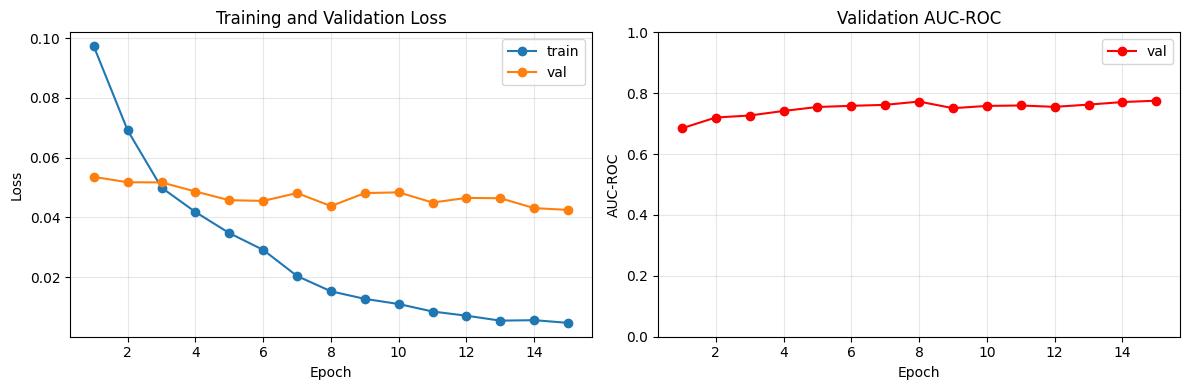

Epoch 15/15 | Train Loss: 0.0047 | Val Loss: 0.0425 | AUC: 0.7754


In [26]:
set_random_seed(42)

num_epoch3 = 15
lr3 = 0.001

model3 = EmbeddingNet().to(device)
criterion3 = TripletLoss(margin=0.25)
optimizer3 = optim.Adam(model3.parameters(), lr=lr3)
scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=5, gamma=0.5)

train(model3, optimizer3, criterion3, train_loader, val_loader, num_epoch3, scheduler3, device)

In [27]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = your_model(images1.to(device))
            emb2 = your_model(images2.to(device))
            # Вы можете изменить функцию расстояния между эмбеддингами, если считаете нужным
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

auc_roc = get_auc_roc(model3)
score = get_score(auc_roc)
print()
print(f'auc_roc = {round(auc_roc, 2)}')
print(f'Балл = {round(score, 2)}')

100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


auc_roc = 0.96
Балл = 3


Чтобы выбить нужный аук-рок, я проделала следующие эксперименты со своей моделью:
1) попробовала использовать `hard triplet loss`, с ним обучение быстрее, однако качество ухудшилось, поэтому дальше без него
2) добавила `scheduler`
3) увеличила `embedding_size` до 512 (это стало главным фактором увеличения качества)
4) увеличила количество эпох до 15



##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

In [28]:
### YOUR CODE HERE ###
from PIL import Image

test_transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

my_face = Image.open('my_face.jpeg').convert('RGB')
my_face_tensor = test_transform(my_face).unsqueeze(0).to(device)

with torch.no_grad():
  model3.eval()
  my_embedding = model3(my_face_tensor).cpu()

In [29]:
all_embeddings = []
all_labels = []
all_images = []
all_indices = []

with torch.no_grad():
    model3.eval()
    for batch_indices, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        embeddings = model3(images)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)
        all_images.append(images.cpu())
        start_ind = batch_indices * test_loader.batch_size
        for i in range(len(images)):
            all_indices.append(start_ind + i)


all_embeddings = torch.cat(all_embeddings)
all_labels = torch.cat(all_labels)
all_images = torch.cat(all_images)

distances = torch.cdist(all_embeddings, my_embedding.cpu())
best_ind = all_indices[torch.argmin(distances).item()]
best_image, best_label = test_ds_first[best_ind]
best_name = test_ds_first.classes[best_label]

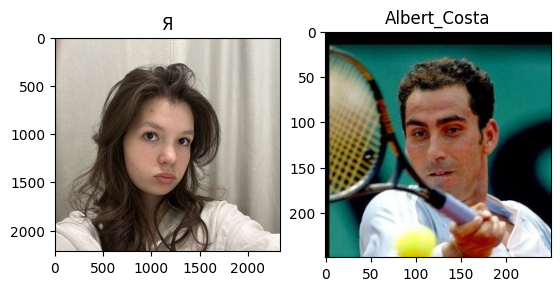

In [31]:
plt.subplot(1, 2, 1)
plt.imshow(Image.open('my_face.jpeg'))
plt.title('Я')

plt.subplot(1, 2, 2)
plt.imshow(best_image.permute(1, 2, 0))
plt.title(best_name)
plt.show()